# **Introduction**

## **Problem Statement**

Build an image classification model for car types using the provided dataset.


**Note:** This part of the project was done on Kaggle to utlize the GPU resources available on the platform.

# **Setup**

In [1]:
!pip install torchinfo

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import models
import os
from typing import List, Any, Tuple
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image 
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import json 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Set the random seed to get reproducible results
torch.manual_seed(42)

# **Model Exploration**

In [5]:
#Get the classification models available on PyTorch for transfer learning
classification_models = models.list_models(module=models)
print(len(classification_models), "classification models:", classification_models)

80 classification models: ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflene

The model of choice for this problem is EfficientNetV2-M.
* After doing some research, I found that variations of EfficientNet performed well on car images compared to other pretrained models [1] [2].
* To confirm this, I have done some experimentaion myself:

|        Model        	| ResNet50 	| EfficientNetV2L 	|
|:-------------------:	|:--------:	|:---------------:	|
| Validation Accuracy 	|    62%   	|       75%       	|


* The model of choice is EfficientNetV2M. This is because the training process of EfficientNetV2L was computationaly expensive.
* Notes:
    * The above models were trained on the train dataset without applying data augmentation for 10 epochs. The goal of the experimentation was to choose the best base model to improve upon. 
    * I wasn't able to do further experimantion due to limited time and GPU resources.

In [6]:
efficientnet_v2_m = models.efficientnet_v2_m(weights=None)

In [7]:
#View the keys of the model's blocks to access them later for modifications
dict(efficientnet_v2_m.named_children()).keys()

dict_keys(['features', 'avgpool', 'classifier'])

In [8]:
#View the model's architecture
efficientnet_v2_m

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

* There are two strategies for Transfer Learning which are Feature Extraction and Fine Tuning. 
* For this problem Fine Tuning is applied to train the model on the specifics of the car body types.

# **Model Creation**

In [9]:
#Model class
class CarTypeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CarTypeClassifier, self).__init__()
        #Load ImageNet weights
        self.model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT) 
        #Change classification head to fully connected layer with 10 output nodes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes) 

        #Freeze all layers 
        for param in self.model.parameters():
            param.requires_grad = False

        #Unfreeze the last two blocks in features for fine tuning
        for i in range(7, 9): 
            for param in self.model.features[i].parameters():
                param.requires_grad = True
            

    def forward(self, x):
        return self.model(x)


# **Data Preprocessing**

**Before passing the images to model, for either training or inference, some tranforms were applied:**

* The images are resized to resize_size=[480]
* central crop of crop_size=[480]
* The values are rescaled to [0.0, 1.0]
* The values are normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

The above transforms follow the preprocessing operations stated in PyTorch docs for EfficientNetV2M [3].

Additional transform:
* Converting the images to grayscale. 
This was done to avoid having the model get distracted by the color of the car [4]. The model should learn to classify the cars based on the shape of the car body and car size.

In addition to the above trasforms, data augmentation is applied to the train dataset:
* RandomHorizontalFlip()
* RandomVerticalFlip()
* RandomRotation(45)

These random transforms are applied to make the model robust to different car angles and different image orientations.

In [10]:
#Set parameters for the transforms and dataloaders
batch_size=64
IMG_SIZE = (480, 480)
size = 480
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(size=size),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) 
    ])

train_dataset = ImageFolder(
    '/kaggle/input/carsimages/cars/train',
    transform=train_transforms,
    )

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size
    )

In [12]:
val_transforms = transforms.Compose([
    transforms.CenterCrop(size=size),
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

val_dataset = ImageFolder(
    '/kaggle/input/carsimages/cars/val',
    transform=val_transforms,
    )

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
    )

In [13]:
train_total = len(train_dataset)
print('Train dataset size:', train_total)
val_total = len(val_dataset)
print('val dataset size:', val_total)
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 6515
val dataset size: 1466
Class names: ['Cab', 'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'SuperCab', 'Van', 'Wagon']


# **Model Training**

In [14]:
#Create the model and move it to the gpu
num_classes = len(class_names)
model = CarTypeClassifier(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 160MB/s]


**Loss Function and Optimizer**
* This is a multiclass classification problem, therefore, categorical cross entropy is used to calculate the loss.
* The optimizer used is Adam optimizer with initial learning rate 0.0001.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#lr_schedule = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
summary(model)

Layer (type:depth-idx)                                       Param #
CarTypeClassifier                                            --
├─EfficientNet: 1-1                                          --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2dNormActivation: 3-1                        (696)
│    │    └─Sequential: 3-2                                  (15,696)
│    │    └─Sequential: 3-3                                  (396,192)
│    │    └─Sequential: 3-4                                  (1,126,048)
│    │    └─Sequential: 3-5                                  (1,686,340)
│    │    └─Sequential: 3-6                                  (6,650,852)
│    │    └─Sequential: 3-7                                  (24,627,064)
│    │    └─Sequential: 3-8                                  17,697,548
│    │    └─Conv2dNormActivation: 3-9                        657,920
│    └─AdaptiveAvgPool2d: 2-2                                --
│    └─Sequential: 2-3           

In [16]:
num_epochs = 50

In [17]:
#Define accuracy and loss calculations which will be used to evaluate the model's performance during training
def Accuracy(correct, total):
    return (correct/total)*100

def Loss(loss, total):
    return loss/total

## **Training Loop**

In [18]:
train_losses=[]
train_accs=[]
train_f1s=[]
val_losses=[]
val_accs=[]
val_f1s=[]
best_val_f1=0

for epoch in range(num_epochs):
    #Model train mode
    model.train()
    running_loss=0
    correct=0
    train_preds=[]
    train_true=[]
    
    for data, labels in tqdm(train_dataloader):
        #Move the data to the GPU
        data, labels = data.to(device), labels.to(device)
        #Clear gradients
        optimizer.zero_grad()
        #Predict
        outputs = model(data)
        #Get prediction labels
        _, preds = torch.max(outputs, 1)
        #Compute loss
        loss = criterion(outputs,labels)
        #Compute gradients
        loss.backward()
        #Update parameters
        optimizer.step()
        
        #Add per batch losses
        running_loss += loss.item() * labels.size(0)
        #Add per batch correct predictions
        correct += torch.sum(preds == labels.data).item()
        #Store true and predicted labels of the epoch
        train_preds.extend(preds.cpu().numpy())
        train_true.extend(labels.data.cpu().numpy())
        
    #Calculate loss per epoch
    train_epoch_loss = Loss(running_loss, train_total)
    #Calculate accuracy per epoch
    train_epoch_acc = Accuracy(correct, train_total)
    #Calculate f1_score per epoch
    train_epoch_f1 = f1_score(train_true, train_preds, average='macro', zero_division=0.0)*100
    
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    train_f1s.append(train_epoch_f1)
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_epoch_loss:.5f}  \t\t Training Accuracy: {train_epoch_acc:.5f}% \t\t Train F1_score: {train_epoch_f1:.5f}%')
    

    #Model evaluation mode
    model.eval()
    running_loss=0
    correct=0
    val_preds=[]
    val_true=[]
    
    #Disable gradient calculation
    with torch.no_grad():
        for data, labels in tqdm(val_dataloader):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs,labels)
            running_loss += loss.item() * labels.size(0)
            correct += torch.sum(preds == labels.data).item()
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.data.cpu().numpy())
            
    val_epoch_loss = Loss(running_loss, val_total)
    val_epoch_acc = Accuracy(correct, val_total)
    val_epoch_f1 = f1_score(val_true, val_preds, average='macro', zero_division=0.0)*100
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    val_f1s.append(val_epoch_f1)
    
    print(f'Epoch {epoch+1} \t\t Validation Loss: {val_epoch_loss:.5f}  \t\t Validation Accuracy: {val_epoch_acc:.5f}% \t\t Validation F1_score: {val_epoch_f1:.5f}%')
    
    #Save model with highest validation f1 score
    if val_epoch_f1> best_val_f1:
        model_scripted = torch.jit.script(model)
        model_scripted.save('car_model_scripted.pt')
        #torch.save(model, 'cars_model.pt')
        print('New best model saved!')
        best_val_f1 = val_epoch_f1

100%|██████████| 102/102 [04:22<00:00,  2.57s/it]


Epoch 1 		 Training Loss: 1.63186  		 Training Accuracy: 43.05449% 		 Train F1_score: 30.92970%


100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 1 		 Validation Loss: 1.18812  		 Validation Accuracy: 58.66303% 		 Validation F1_score: 46.98303%
New best model saved!


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 2 		 Training Loss: 1.20497  		 Training Accuracy: 57.40599% 		 Train F1_score: 48.97761%


100%|██████████| 23/23 [00:29<00:00,  1.29s/it]


Epoch 2 		 Validation Loss: 1.04452  		 Validation Accuracy: 64.25648% 		 Validation F1_score: 56.70548%
New best model saved!


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 3 		 Training Loss: 1.00855  		 Training Accuracy: 64.38987% 		 Train F1_score: 58.03676%


100%|██████████| 23/23 [00:29<00:00,  1.29s/it]


Epoch 3 		 Validation Loss: 1.01543  		 Validation Accuracy: 64.18827% 		 Validation F1_score: 60.79079%
New best model saved!


100%|██████████| 102/102 [03:33<00:00,  2.10s/it]


Epoch 4 		 Training Loss: 0.85271  		 Training Accuracy: 70.09977% 		 Train F1_score: 65.51729%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 4 		 Validation Loss: 0.96215  		 Validation Accuracy: 66.71214% 		 Validation F1_score: 63.70820%
New best model saved!


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 5 		 Training Loss: 0.75212  		 Training Accuracy: 74.36685% 		 Train F1_score: 70.71583%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 5 		 Validation Loss: 1.03614  		 Validation Accuracy: 65.00682% 		 Validation F1_score: 60.55351%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 6 		 Training Loss: 0.67073  		 Training Accuracy: 76.53108% 		 Train F1_score: 73.81639%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 6 		 Validation Loss: 0.91703  		 Validation Accuracy: 69.16780% 		 Validation F1_score: 66.52949%
New best model saved!


100%|██████████| 102/102 [03:33<00:00,  2.09s/it]


Epoch 7 		 Training Loss: 0.58092  		 Training Accuracy: 80.07675% 		 Train F1_score: 77.88228%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 7 		 Validation Loss: 0.96433  		 Validation Accuracy: 69.09959% 		 Validation F1_score: 65.10152%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 8 		 Training Loss: 0.51568  		 Training Accuracy: 82.73216% 		 Train F1_score: 81.21748%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 8 		 Validation Loss: 0.90244  		 Validation Accuracy: 71.35061% 		 Validation F1_score: 69.34829%
New best model saved!


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 9 		 Training Loss: 0.46753  		 Training Accuracy: 83.77590% 		 Train F1_score: 82.67803%


100%|██████████| 23/23 [00:29<00:00,  1.29s/it]


Epoch 9 		 Validation Loss: 0.95937  		 Validation Accuracy: 69.84993% 		 Validation F1_score: 67.97401%


100%|██████████| 102/102 [03:33<00:00,  2.10s/it]


Epoch 10 		 Training Loss: 0.41607  		 Training Accuracy: 86.12433% 		 Train F1_score: 84.63433%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 10 		 Validation Loss: 0.96706  		 Validation Accuracy: 68.89495% 		 Validation F1_score: 68.78098%


100%|██████████| 102/102 [03:35<00:00,  2.12s/it]


Epoch 11 		 Training Loss: 0.37371  		 Training Accuracy: 87.52111% 		 Train F1_score: 86.73318%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 11 		 Validation Loss: 0.96547  		 Validation Accuracy: 68.82674% 		 Validation F1_score: 68.25650%


100%|██████████| 102/102 [03:33<00:00,  2.09s/it]


Epoch 12 		 Training Loss: 0.34350  		 Training Accuracy: 87.92018% 		 Train F1_score: 86.87447%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 12 		 Validation Loss: 0.88484  		 Validation Accuracy: 71.62347% 		 Validation F1_score: 69.57958%
New best model saved!


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 13 		 Training Loss: 0.32438  		 Training Accuracy: 89.07137% 		 Train F1_score: 88.53349%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 13 		 Validation Loss: 0.83916  		 Validation Accuracy: 74.28377% 		 Validation F1_score: 72.35368%
New best model saved!


100%|██████████| 102/102 [03:36<00:00,  2.12s/it]


Epoch 14 		 Training Loss: 0.28053  		 Training Accuracy: 90.86723% 		 Train F1_score: 90.30953%


100%|██████████| 23/23 [00:30<00:00,  1.33s/it]


Epoch 14 		 Validation Loss: 0.92376  		 Validation Accuracy: 72.57844% 		 Validation F1_score: 70.33466%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 15 		 Training Loss: 0.26717  		 Training Accuracy: 90.99002% 		 Train F1_score: 90.47262%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 15 		 Validation Loss: 0.93590  		 Validation Accuracy: 72.16917% 		 Validation F1_score: 69.85845%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 16 		 Training Loss: 0.24296  		 Training Accuracy: 91.80353% 		 Train F1_score: 91.25322%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 16 		 Validation Loss: 0.99019  		 Validation Accuracy: 71.82810% 		 Validation F1_score: 69.93184%


100%|██████████| 102/102 [03:36<00:00,  2.12s/it]


Epoch 17 		 Training Loss: 0.22121  		 Training Accuracy: 92.77053% 		 Train F1_score: 92.54202%


100%|██████████| 23/23 [00:30<00:00,  1.33s/it]


Epoch 17 		 Validation Loss: 0.99559  		 Validation Accuracy: 72.10095% 		 Validation F1_score: 70.42789%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 18 		 Training Loss: 0.21727  		 Training Accuracy: 92.43285% 		 Train F1_score: 92.16009%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 18 		 Validation Loss: 1.00684  		 Validation Accuracy: 71.41883% 		 Validation F1_score: 70.36687%


100%|██████████| 102/102 [03:36<00:00,  2.13s/it]


Epoch 19 		 Training Loss: 0.20129  		 Training Accuracy: 93.53799% 		 Train F1_score: 93.08736%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 19 		 Validation Loss: 0.98172  		 Validation Accuracy: 71.28240% 		 Validation F1_score: 69.22111%


100%|██████████| 102/102 [03:38<00:00,  2.15s/it]


Epoch 20 		 Training Loss: 0.18810  		 Training Accuracy: 93.96777% 		 Train F1_score: 93.68227%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 20 		 Validation Loss: 0.98657  		 Validation Accuracy: 71.89632% 		 Validation F1_score: 69.53028%


100%|██████████| 102/102 [03:35<00:00,  2.12s/it]


Epoch 21 		 Training Loss: 0.16729  		 Training Accuracy: 94.81197% 		 Train F1_score: 94.66584%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 21 		 Validation Loss: 0.97806  		 Validation Accuracy: 71.14598% 		 Validation F1_score: 69.82064%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 22 		 Training Loss: 0.16252  		 Training Accuracy: 94.62778% 		 Train F1_score: 94.42208%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 22 		 Validation Loss: 0.97545  		 Validation Accuracy: 72.30559% 		 Validation F1_score: 70.01348%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 23 		 Training Loss: 0.15957  		 Training Accuracy: 94.67383% 		 Train F1_score: 94.25646%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 23 		 Validation Loss: 0.89735  		 Validation Accuracy: 74.28377% 		 Validation F1_score: 72.73752%
New best model saved!


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 24 		 Training Loss: 0.13540  		 Training Accuracy: 95.47199% 		 Train F1_score: 95.38873%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 24 		 Validation Loss: 1.03040  		 Validation Accuracy: 71.14598% 		 Validation F1_score: 70.83011%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 25 		 Training Loss: 0.15585  		 Training Accuracy: 95.08826% 		 Train F1_score: 94.76515%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 25 		 Validation Loss: 0.99505  		 Validation Accuracy: 71.55525% 		 Validation F1_score: 70.57846%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 26 		 Training Loss: 0.14212  		 Training Accuracy: 95.61013% 		 Train F1_score: 95.56710%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 26 		 Validation Loss: 1.00367  		 Validation Accuracy: 71.75989% 		 Validation F1_score: 71.81508%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 27 		 Training Loss: 0.12565  		 Training Accuracy: 95.82502% 		 Train F1_score: 95.70698%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 27 		 Validation Loss: 1.03517  		 Validation Accuracy: 72.78308% 		 Validation F1_score: 70.92520%


100%|██████████| 102/102 [03:36<00:00,  2.12s/it]


Epoch 28 		 Training Loss: 0.12446  		 Training Accuracy: 96.22410% 		 Train F1_score: 96.09116%


100%|██████████| 23/23 [00:30<00:00,  1.33s/it]


Epoch 28 		 Validation Loss: 1.05562  		 Validation Accuracy: 72.98772% 		 Validation F1_score: 71.47249%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 29 		 Training Loss: 0.12130  		 Training Accuracy: 96.16270% 		 Train F1_score: 96.01724%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 29 		 Validation Loss: 0.96266  		 Validation Accuracy: 72.44202% 		 Validation F1_score: 70.50045%


100%|██████████| 102/102 [03:36<00:00,  2.13s/it]


Epoch 30 		 Training Loss: 0.11872  		 Training Accuracy: 96.00921% 		 Train F1_score: 96.17968%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 30 		 Validation Loss: 1.00624  		 Validation Accuracy: 72.57844% 		 Validation F1_score: 70.89042%


100%|██████████| 102/102 [03:34<00:00,  2.11s/it]


Epoch 31 		 Training Loss: 0.10929  		 Training Accuracy: 96.50038% 		 Train F1_score: 96.50963%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 31 		 Validation Loss: 0.98167  		 Validation Accuracy: 74.14734% 		 Validation F1_score: 71.31600%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 32 		 Training Loss: 0.09853  		 Training Accuracy: 97.06830% 		 Train F1_score: 97.07355%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 32 		 Validation Loss: 1.06354  		 Validation Accuracy: 71.96453% 		 Validation F1_score: 70.76549%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 33 		 Training Loss: 0.10043  		 Training Accuracy: 96.94551% 		 Train F1_score: 96.81218%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 33 		 Validation Loss: 0.98479  		 Validation Accuracy: 74.01091% 		 Validation F1_score: 72.01671%


100%|██████████| 102/102 [03:34<00:00,  2.11s/it]


Epoch 34 		 Training Loss: 0.10595  		 Training Accuracy: 96.54643% 		 Train F1_score: 96.49635%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 34 		 Validation Loss: 1.02298  		 Validation Accuracy: 72.03274% 		 Validation F1_score: 70.45932%


100%|██████████| 102/102 [03:34<00:00,  2.11s/it]


Epoch 35 		 Training Loss: 0.09284  		 Training Accuracy: 97.12970% 		 Train F1_score: 97.11002%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 35 		 Validation Loss: 1.05987  		 Validation Accuracy: 71.21419% 		 Validation F1_score: 69.31067%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 36 		 Training Loss: 0.09481  		 Training Accuracy: 97.05295% 		 Train F1_score: 96.81429%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 36 		 Validation Loss: 0.97433  		 Validation Accuracy: 74.07913% 		 Validation F1_score: 72.32029%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 37 		 Training Loss: 0.09717  		 Training Accuracy: 97.05295% 		 Train F1_score: 97.03441%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 37 		 Validation Loss: 1.00230  		 Validation Accuracy: 74.35198% 		 Validation F1_score: 72.29738%


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Epoch 38 		 Training Loss: 0.09368  		 Training Accuracy: 96.69992% 		 Train F1_score: 96.78872%


100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Epoch 38 		 Validation Loss: 1.03130  		 Validation Accuracy: 72.44202% 		 Validation F1_score: 70.79409%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 39 		 Training Loss: 0.09619  		 Training Accuracy: 96.85342% 		 Train F1_score: 96.79306%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 39 		 Validation Loss: 0.95669  		 Validation Accuracy: 74.07913% 		 Validation F1_score: 71.41415%


100%|██████████| 102/102 [03:32<00:00,  2.09s/it]


Epoch 40 		 Training Loss: 0.08475  		 Training Accuracy: 97.34459% 		 Train F1_score: 97.22883%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 40 		 Validation Loss: 0.98045  		 Validation Accuracy: 74.89768% 		 Validation F1_score: 72.79553%
New best model saved!


100%|██████████| 102/102 [03:32<00:00,  2.09s/it]


Epoch 41 		 Training Loss: 0.07789  		 Training Accuracy: 97.57483% 		 Train F1_score: 97.48764%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 41 		 Validation Loss: 1.03300  		 Validation Accuracy: 73.53342% 		 Validation F1_score: 71.43546%


100%|██████████| 102/102 [03:32<00:00,  2.08s/it]


Epoch 42 		 Training Loss: 0.07857  		 Training Accuracy: 97.28319% 		 Train F1_score: 97.08771%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 42 		 Validation Loss: 0.90195  		 Validation Accuracy: 76.19372% 		 Validation F1_score: 74.94341%
New best model saved!


100%|██████████| 102/102 [03:32<00:00,  2.08s/it]


Epoch 43 		 Training Loss: 0.07357  		 Training Accuracy: 97.46738% 		 Train F1_score: 97.37692%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 43 		 Validation Loss: 1.03649  		 Validation Accuracy: 73.05593% 		 Validation F1_score: 71.22287%


100%|██████████| 102/102 [03:33<00:00,  2.09s/it]


Epoch 44 		 Training Loss: 0.07835  		 Training Accuracy: 97.49808% 		 Train F1_score: 97.34595%


100%|██████████| 23/23 [00:29<00:00,  1.29s/it]


Epoch 44 		 Validation Loss: 0.99487  		 Validation Accuracy: 74.48840% 		 Validation F1_score: 72.90707%


100%|██████████| 102/102 [03:32<00:00,  2.08s/it]


Epoch 45 		 Training Loss: 0.08332  		 Training Accuracy: 97.29854% 		 Train F1_score: 97.08195%


100%|██████████| 23/23 [00:29<00:00,  1.29s/it]


Epoch 45 		 Validation Loss: 0.95838  		 Validation Accuracy: 74.82947% 		 Validation F1_score: 72.93542%


100%|██████████| 102/102 [03:32<00:00,  2.09s/it]


Epoch 46 		 Training Loss: 0.07147  		 Training Accuracy: 97.55948% 		 Train F1_score: 97.62044%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 46 		 Validation Loss: 1.02695  		 Validation Accuracy: 74.89768% 		 Validation F1_score: 72.97527%


100%|██████████| 102/102 [03:33<00:00,  2.10s/it]


Epoch 47 		 Training Loss: 0.07884  		 Training Accuracy: 97.25249% 		 Train F1_score: 97.03374%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 47 		 Validation Loss: 1.04913  		 Validation Accuracy: 73.80628% 		 Validation F1_score: 71.71740%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 48 		 Training Loss: 0.06420  		 Training Accuracy: 97.98926% 		 Train F1_score: 97.88040%


100%|██████████| 23/23 [00:29<00:00,  1.30s/it]


Epoch 48 		 Validation Loss: 0.98980  		 Validation Accuracy: 73.80628% 		 Validation F1_score: 71.50153%


100%|██████████| 102/102 [03:34<00:00,  2.11s/it]


Epoch 49 		 Training Loss: 0.06606  		 Training Accuracy: 97.82041% 		 Train F1_score: 97.58563%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


Epoch 49 		 Validation Loss: 1.01618  		 Validation Accuracy: 74.14734% 		 Validation F1_score: 71.26524%


100%|██████████| 102/102 [03:34<00:00,  2.10s/it]


Epoch 50 		 Training Loss: 0.06022  		 Training Accuracy: 98.15810% 		 Train F1_score: 98.20948%


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]

Epoch 50 		 Validation Loss: 1.11940  		 Validation Accuracy: 73.12415% 		 Validation F1_score: 71.76247%


In [19]:
#Save the labels dictionary
class_dict = dict((v,k) for k,v in train_dataset.class_to_idx.items())

with open("Classes Dict.json", "w") as outfile: 
    json.dump(class_dict, outfile)

# **Model Evaluation**

In [20]:
def plot_metrics(num_epochs, train_metric, val_metric, train_label, val_label, x_label, y_label, title):
    epochs = list(range(1, num_epochs+1))
    plt.plot(epochs, train_metric, color='b', label=train_label)
    plt.plot(epochs, val_metric, color='r', label=val_label)
    
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title)
    
    plt.legend() 
    plt.show() 

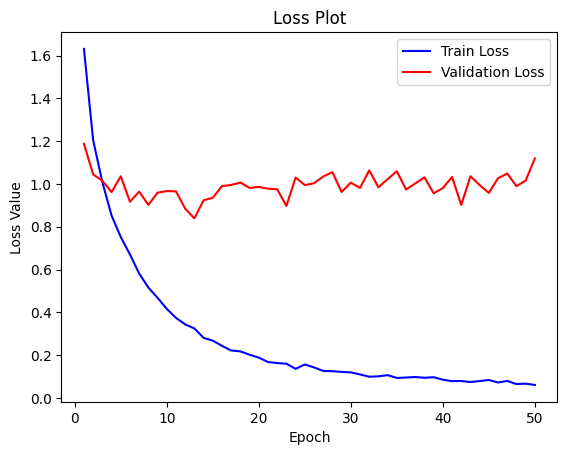

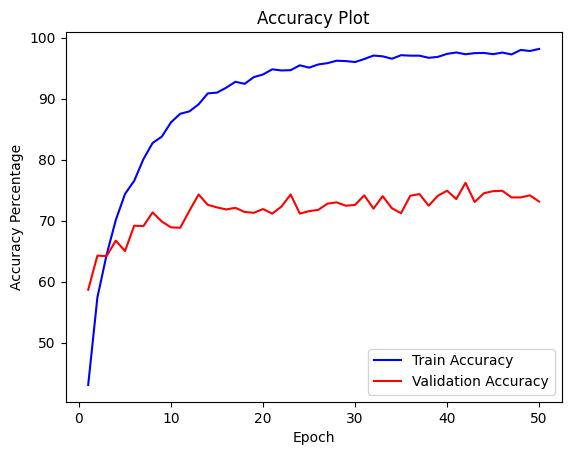

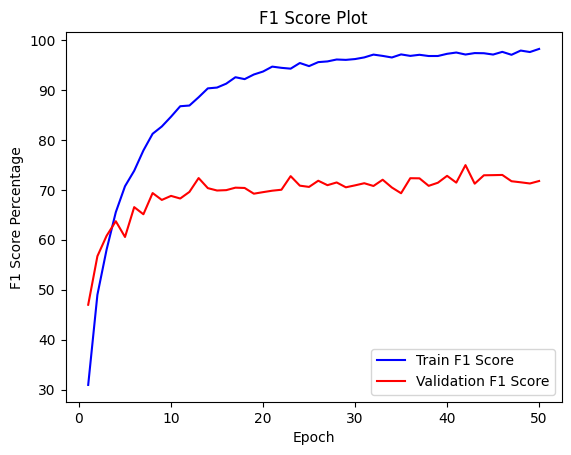

In [21]:
plot_metrics(num_epochs, train_losses, val_losses, 'Train Loss', 'Validation Loss', 'Epoch', 'Loss Value', 'Loss Plot')
plot_metrics(num_epochs, train_accs, val_accs, 'Train Accuracy', 'Validation Accuracy', 'Epoch', 'Accuracy Percentage', 'Accuracy Plot')
plot_metrics(num_epochs, train_f1s, val_f1s, 'Train F1 Score', 'Validation F1 Score', 'Epoch', 'F1 Score Percentage', 'F1 Score Plot')

In [22]:
#Predict the validation datset
val_preds=[]
val_true=[]
correct = 0

model = torch.jit.load('/kaggle/working/car_model_scripted.pt')
model.eval()
with torch.no_grad():
    for data, labels in tqdm(val_dataloader):
        
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data).item()
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.data.cpu().numpy())

100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


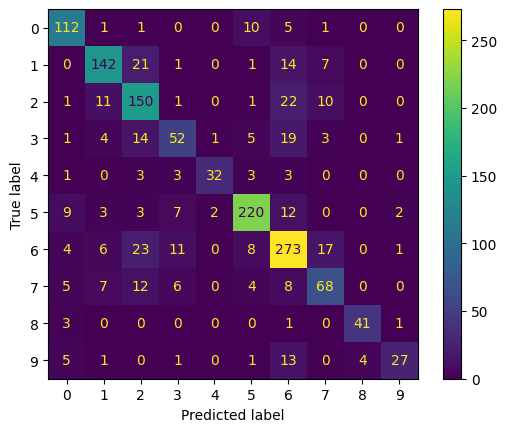

In [23]:
le_classes = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(val_true, val_preds, labels=le_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_classes)

disp.plot()
plt.show()

In [24]:
val_true_labels = [class_dict[label] for label in val_true]
val_preds_labels = [class_dict[label] for label in val_preds]

In [25]:
print(classification_report(val_true_labels, val_preds_labels))

              precision    recall  f1-score   support

         Cab       0.79      0.86      0.83       130
 Convertible       0.81      0.76      0.79       186
       Coupe       0.66      0.77      0.71       196
   Hatchback       0.63      0.52      0.57       100
     Minivan       0.91      0.71      0.80        45
         SUV       0.87      0.85      0.86       258
       Sedan       0.74      0.80      0.77       343
    SuperCab       0.64      0.62      0.63       110
         Van       0.91      0.89      0.90        46
       Wagon       0.84      0.52      0.64        52

    accuracy                           0.76      1466
   macro avg       0.78      0.73      0.75      1466
weighted avg       0.77      0.76      0.76      1466



# **References**

[1] https://paperswithcode.com/sota/image-classification-on-stanford-cars

[2] https://medium.com/@albionkrasniqi22_80133/vehicle-classification-742403117f43

[3] https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_m.html#torchvision.models.efficientnet_v2_m